In [215]:
from stock_prediction import ARIMAXGBoost
from stock_prediction.core import GradientDescentRegressor
import numpy as np
from matplotlib import pyplot as plt


In [216]:
# This script demonstrates how to use the ARIMAXGBoost model for stock price prediction.
from stock_prediction import StockPredictor
from pytickersymbols import PyTickerSymbols
import random
# Example: Get a random stock from S&P 500
# stock_data = PyTickerSymbols().get_stocks_by_index('S&P 500')
# stock_data = list(stock_data)
# stock_data = [stock_data[i]['symbol']  for i in range(len(stock_data))]
# stock_data = StockPredictor(random.choice(stock_data), "2018-01-01") 

stock = StockPredictor("AAPL", "2018-01-01")  # Example with Apple Inc.
stock.load_data() # Load the stock data after feature engineering
stock_data = stock.data  # Access the processed stock data

# Use OHCLV data for training
# import yfinance as yf
# stock = yf.Ticker("NVDA")
# stock_data = stock.history(period="5y", interval="1d")





X = stock_data.drop(columns="Close")
y = stock_data["Close"]

# Split the data into training and testing sets
train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
import pandas as pd
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

Successfully loaded data from Yahoo Finance for AAPL
Trying to fetch economic data from cache...
Cache fetch failed: name 'get_cached_data' is not defined. Downloading fresh data...
Data loaded for AAPL with 1634 rows.


In [217]:
# Shape of the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1143, 40), (1143,), (491, 40), (491,))

In [218]:
X_train.columns

Index(['High', 'Low', 'Open', 'Volume', 'MA_50', 'MA_200', 'MA_7', 'MA_21',
       'rolling_std', 'rolling_min', 'rolling_median', 'rolling_sum',
       'rolling_var', 'rolling_ema', 'rolling_25p', 'rolling_75p', 'RSI',
       'MACD', 'Williams_%R', 'Stochastic_%K', 'Stochastic_%D', 'Price_Change',
       'Momentum_Divergence', 'ATR', 'Upper_Bollinger', 'Lower_Bollinger',
       'VWAP', 'Daily Returns', 'Volatility', 'Momentum_Score',
       'Momentum_Interaction', 'Volatility_Adj_Momentum', 'SP500', 'TNX',
       'Treasury_Yield', 'USDCAD=X', 'Tech', 'Fin', 'VIX', 'Energy'],
      dtype='object')

In [219]:
# Ensure the n_epoches is fixed
n_epochs = 2000

In [ ]:
# Import various optimizers
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
vanilla_sgd = SGDRegressor(loss='squared_error', penalty='elasticnet',random_state=42, verbose=10000,
                           learning_rate='constant', eta0=0.01, alpha=0.0001, l1_ratio=0.5,
                           n_iter_no_change=10,  validation_fraction=0.1,)
# Track loss manually
vanilla_sgd_loss_history = []
counter = 0
for _ in range(n_epochs):
    vanilla_sgd.partial_fit(X_train, y_train)  # Train for one epoch
    y_pred = vanilla_sgd.predict(X_train)
    loss = mean_squared_error(y_train, y_pred)
    vanilla_sgd_loss_history.append(loss)
    counter += 1
    print(f"Epoch {counter}")
  
# Fit the model with entire labelled data
# vanilla_sgd = SGDRegressor(loss='squared_error', random_state=42, verbose=10000)  
# vanilla_sgd.fit(X_train, y_train)

In [221]:
# Attempt to use the GradientDescentRegressor with different configurations

# # model2 is selected by Bayesian optimization CV (Seems not good)
# model2 = GradientDescentRegressor(alpha = 0.04106938548944606,
#                 batch_size = 195,
#                 l1_ratio = 0.09329351308489861,
#                 lr = 0.1647418008086539,
#                 momentum = 0.8015665767210205,
#                 # n_iter = 614,
#                 n_iter = 5000,
#                 random_state = 42,
#                 rmsprop = True
#                 )
# model2.fit(X_train, y_train)


# # model3 is model used in the arimaxgboost
# model3 = GradientDescentRegressor(
#             # n_iter=1000,
#             n_iter = 5000,
#             lr=0.05,
#             alpha=0.01,
#             l1_ratio=0.01,
#             momentum=0.9,
#             rmsprop=False,
#             random_state=42,
#             # early_stopping=True,
#         )
# model3.fit(X_train, y_train)


# # model4 is rmsprop = True version of model3
# model4 = GradientDescentRegressor(
#             # n_iter=1000,
#             n_iter = 5000,
#             lr=0.05,
#             alpha=0.01,
#             l1_ratio=0.01,
#             momentum=0.9,
#             rmsprop=True,
#             random_state=42,
#             # early_stopping=True,
#         )
# model4.fit(X_train, y_train)


# default model without any tuning (with more iterations for illustration)
model5 = GradientDescentRegressor(
            n_iter=n_epochs,
            rmsprop=False,
            random_state=42,
        )
model5.fit(X_train, y_train)

# # Start from default model and use optimization
# model6 = GradientDescentRegressor(
#             n_iter=n_epochs,
#             rmsprop=False,
#             random_state=42,
#         )
# _ = model6.optimize_hyperparameters(X_train, y_train, n_iter=500)
# print(_)
# # print(f"GD model parameters: { {k: model6.__dict__[k] for k in list(model6.__dict__.keys())[:8]}}"
# #             )
# model6.fit(X_train, y_train)

# loss_history2 = np.array(model2.loss_history)
# mse_history2 = np.array(model2.mse_history)
# # coef_history2 = np.array(model2.coef_history)
# # grad_history2 = np.array(model2.grad_history)

# loss_history3 = np.array(model3.loss_history)
# mse_history3 = np.array(model3.mse_history)
# # coef_history3 = np.array(model3.coef_history)
# # grad_history3 = np.array(model3.grad_history)

# loss_history4 = np.array(model4.loss_history)
# mse_history4 = np.array(model4.mse_history)
# # coef_history4 = np.array(model4.coef_history)
# # grad_history4 = np.array(model4.grad_history)

loss_history5 = np.array(model5.loss_history)
mse_history5 = np.array(model5.mse_history)
coef_history5 = np.array(model5.coef_history)
grad_history5 = np.array(model5.grad_history)

# loss_history6 = np.array(model6.loss_history)
# mse_history6 = np.array(model6.mse_history)
# # coef_history6 = np.array(model6.coef_history)
# # grad_history6 = np.array(model6.grad_history)

In [ ]:

plt.figure(figsize=(20, 10))
start = 0
end = 100
model5.loss_mape_history = np.array(model5.loss_mape_history)
plt.plot(range(start,end), model5.loss_mape_history[start:end], label="loss_mape_history")
# plt.plot(range(start,end), model5.loss_history[start:end], label="loss_history")


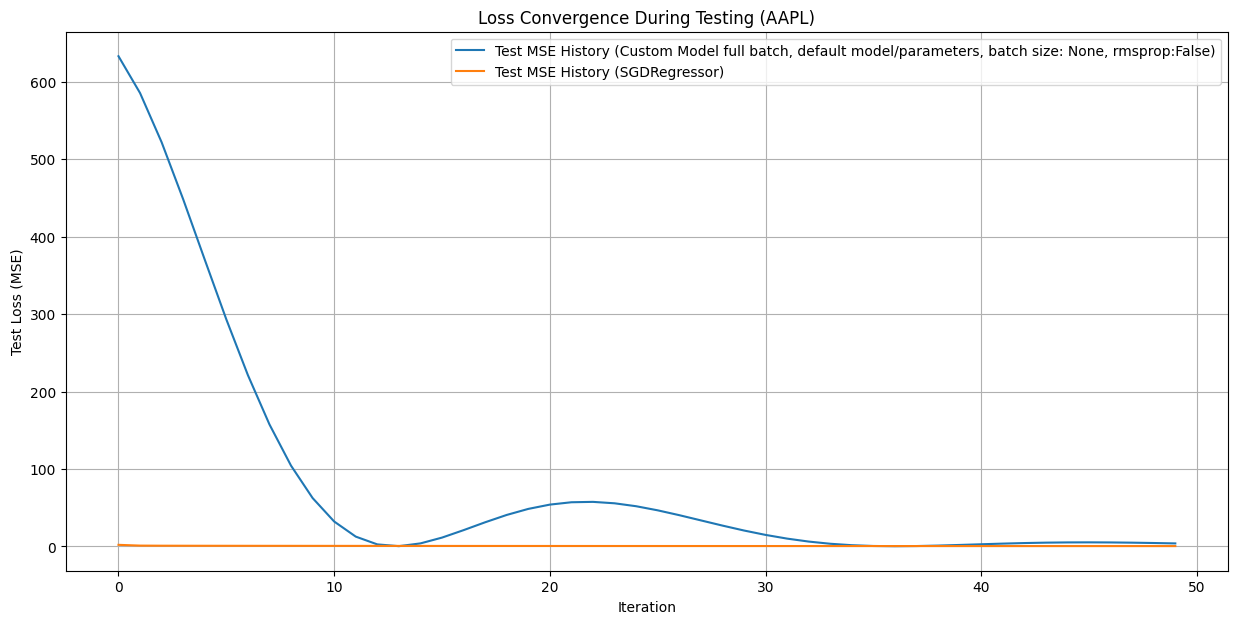

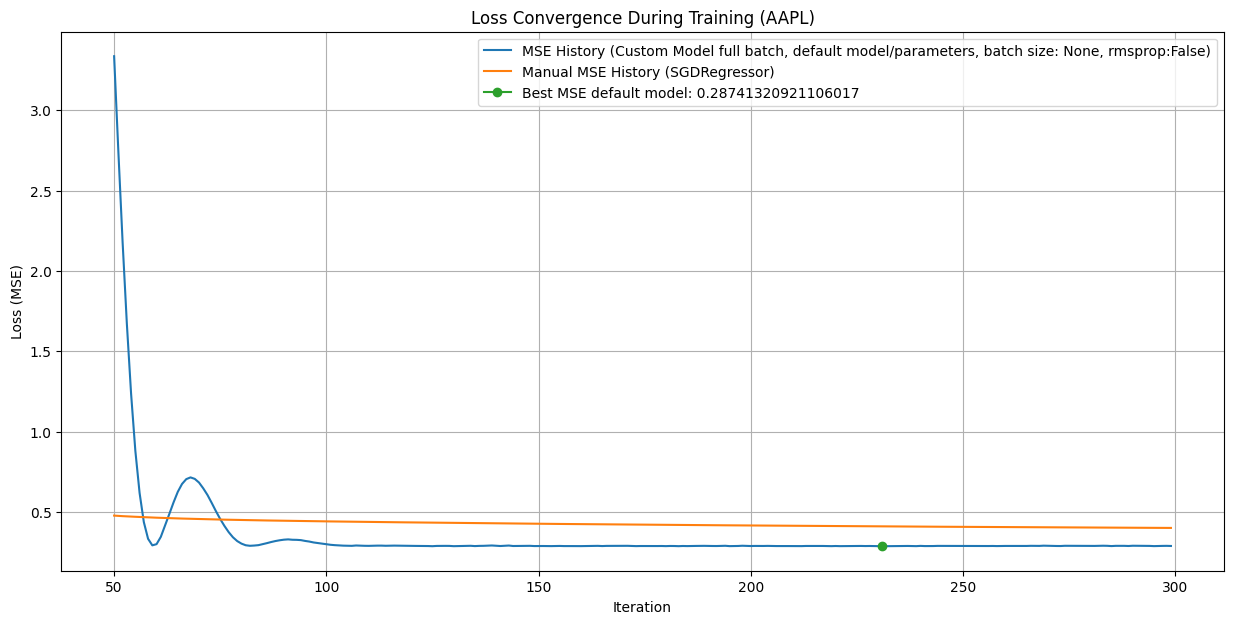

In [256]:
# matches the way of calculating loss 


plt.figure(figsize=(15, 7))
start = 0
end = 50
plt.plot(range(start,end),mse_history5[start:end], label=f'Test MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')
plt.plot(range(start,end), np.array(vanilla_sgd_loss_history)[start:end], label='Test MSE History (SGDRegressor)')

if start <= np.argmin(mse_history5) <= end:
    plt.plot(np.argmin(mse_history5), mse_history5.min(), 'o', label=f'Best MSE default model: {mse_history5[np.argmin(mse_history5)]} at epoch {np.argmin(mse_history5)}')
plt.xlabel("Iteration")
plt.ylabel("Test Loss (MSE)")
plt.title(f"Loss Convergence During Testing ({stock.symbol})")
plt.legend()
plt.grid(True)
plt.show()



for start, end in zip(range(50, 500-250+1+50, 250), range(300, 500+1, 250)):
   plt.figure(figsize=(15, 7))

   # plt.plot(range(start,end),mse_history2[start:end], label=f'MSE History (Custom Model mini-batch, batch size:{model2.batch_size}, rmsprop:{model2.rmsprop})')
   # plt.plot(range(start,end),mse_history3[start:end], label=f'MSE History (Custom Model full batch, batch size: {model3.batch_size}, rmsprop:{model3.rmsprop})')
   # plt.plot(range(start,end),mse_history4[start:end], label=f'MSE History (Custom Model full batch, batch size: {model4.batch_size}, rmsprop:{model4.rmsprop})')
   plt.plot(range(start,end),mse_history5[start:end], label=f'MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')
   # plt.plot(range(start,end),mse_history6[start:end], label=f'MSE History (Custom Model full batch, optimized parameters, batch size: {model6.batch_size}, rmsprop:{model6.rmsprop})')
   plt.plot(range(start,end), np.array(vanilla_sgd_loss_history)[start:end], label='Manual MSE History (SGDRegressor)')
   if start <= np.argmin(mse_history5) <= end:
      plt.plot(np.argmin(mse_history5), mse_history5[np.argmin(mse_history5)], marker = 'o', label='Best MSE default model: {}'.format(mse_history5[np.argmin(mse_history5)]))
   # plt.plot(np.argmin(mse_history6), mse_history6[np.argmin(mse_history6)], marker = 'o', label='Best MSE optimized model: {}'.format(mse_history6[np.argmin(mse_history6)]))
      
   # if start <= np.argmin(vanilla_sgd_loss_history) <= end:
   #    plt.plot(np.argmin(vanilla_sgd_loss_history), np.array(vanilla_sgd_loss_history).min(), 'ro', label='Best MSE SGDRegressor: {}'.format(np.array(vanilla_sgd_loss_history).min()))
   plt.xlabel("Iteration")
   plt.ylabel("Loss (MSE)")
   plt.title(f"Loss Convergence During Training ({stock.symbol})")
   plt.legend()
   plt.grid(True)
   plt.show()


In [ ]:
# Check if the custom model's MSE is less than the SGDRegressor's MSE
tol = 0
for i in range(len(mse_history5 < vanilla_sgd_loss_history)):
    if (mse_history5 < vanilla_sgd_loss_history)[i]:
        print(f"Epoch {i}: Custom Model MSE {mse_history5[i]} < SGDRegressor MSE {vanilla_sgd_loss_history[i]}")
        tol += 1
        if tol == 10:
            break

In [ ]:
# Want to see TEST loss over epochs
test_vanilla_sgd_loss_history = []
test_vanilla_sgd = SGDRegressor(loss='squared_error', penalty='elasticnet',random_state=42, verbose=10000,
                            learning_rate='constant', eta0=0.01, alpha=0.0001, l1_ratio=0.0001)
counter = 0
for _ in range(n_epochs):
     # Test for one epoch
    test_vanilla_sgd.partial_fit(X_train, y_train)  # Train for one epoch
    y_pred =  test_vanilla_sgd.predict(X_test)
    loss = mean_squared_error(y_test, y_pred)
    test_vanilla_sgd_loss_history.append(loss)
    counter += 1
    print(f"Epoch {counter}")


test_model5 = GradientDescentRegressor(
            n_iter=n_epochs,
            rmsprop=False,
            random_state=42,
        )
test_model5._fit_gd(X_train, y_train, X_test, y_test)
test_mse_history5 = np.array(test_model5.val_mse_history)
mse_history5 = np.array(test_model5.mse_history)


# test_model6 = GradientDescentRegressor(
#             n_iter=n_epochs,
#             rmsprop=False,
#             random_state=42,
#         )
# _ = test_model6.optimize_hyperparameters(X_train, y_train,n_iter=500)
# print(_)
# test_model6._fit_gd(X_train, y_train, X_test, y_test)
# test_mse_history6 = np.array(test_model6.val_mse_history)
# mse_history6 = np.array(test_model6.mse_history)


  


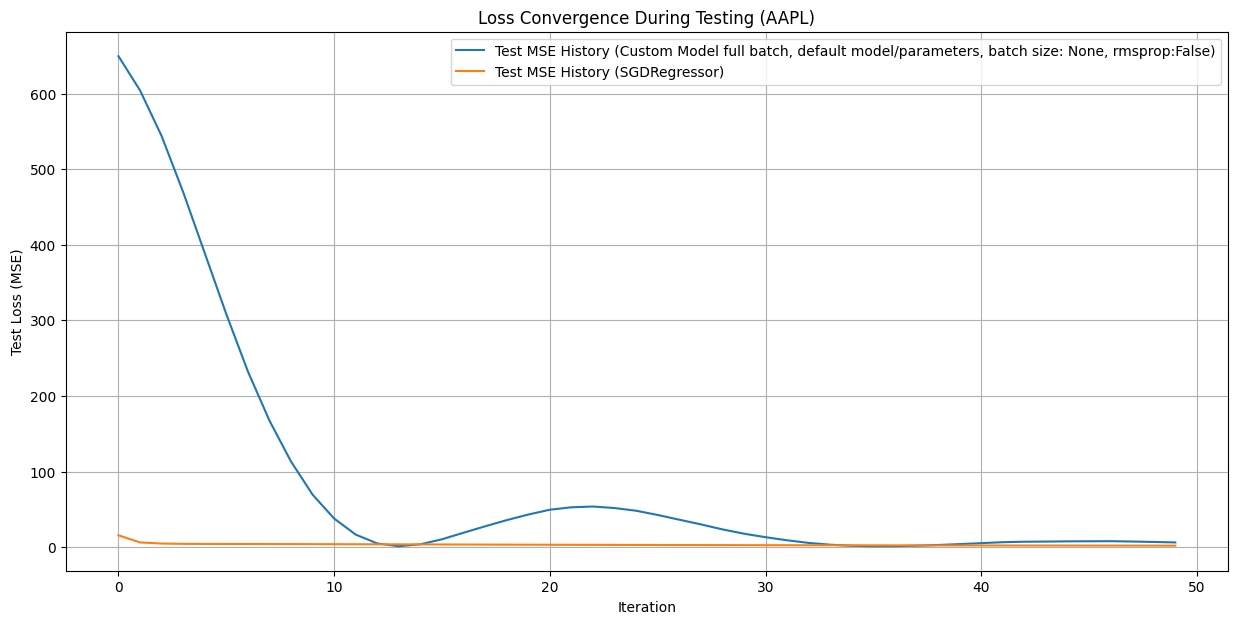

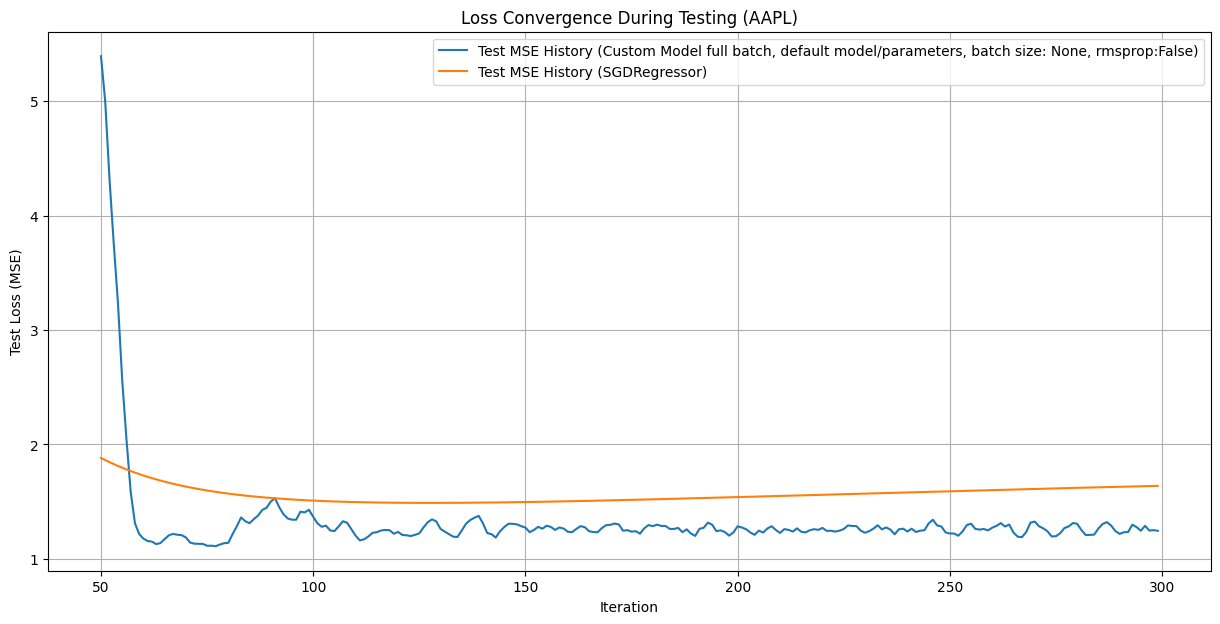

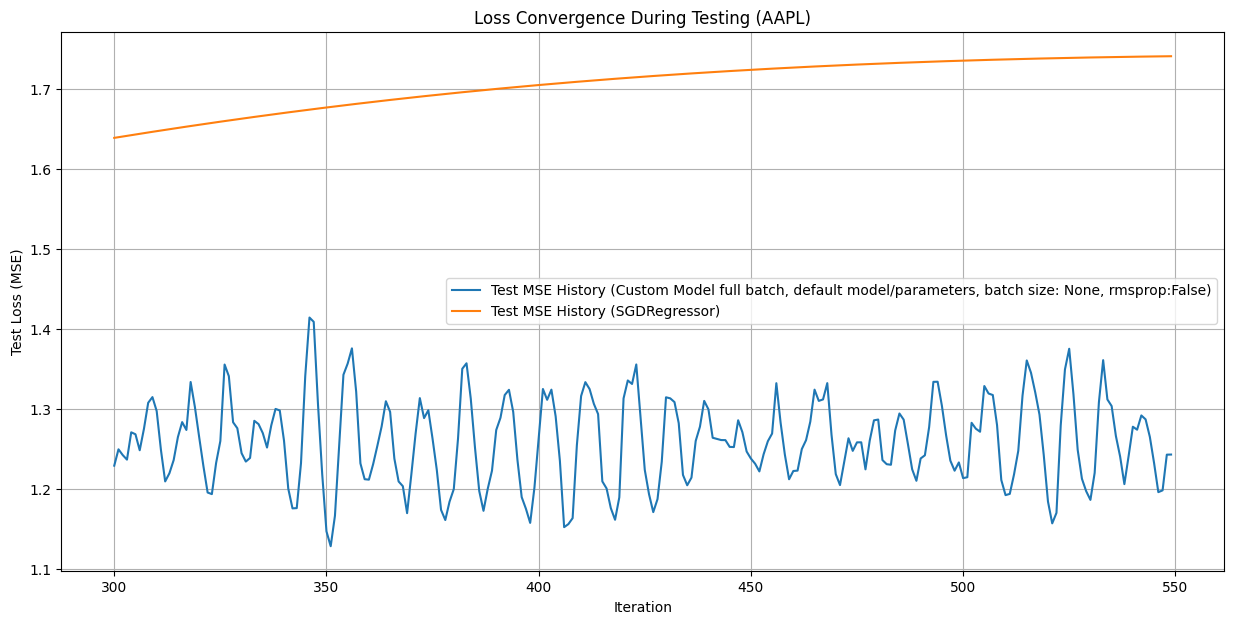

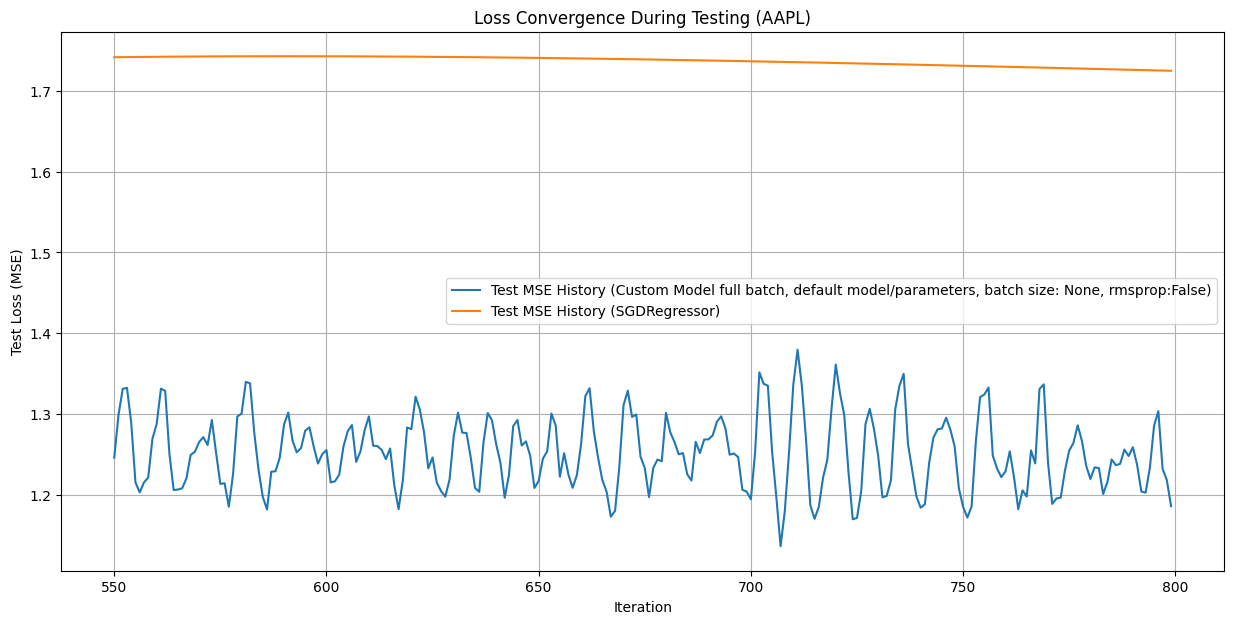

In [248]:
plt.figure(figsize=(15, 7))
start = 0
end = 50
plt.plot(range(start,end),test_mse_history5[start:end], label=f'Test MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')
plt.plot(range(start,end), np.array(test_vanilla_sgd_loss_history)[start:end], label='Test MSE History (SGDRegressor)')

if start <= np.argmin(test_mse_history5) <= end:
    plt.plot(np.argmin(test_mse_history5), test_mse_history5.min(), 'o', label=f'Best MSE default model: {test_mse_history5[np.argmin(test_mse_history5)]} at epoch {np.argmin(test_mse_history5)}')
plt.xlabel("Iteration")
plt.ylabel("Test Loss (MSE)")
plt.title(f"Loss Convergence During Testing ({stock.symbol})")
plt.legend()
plt.grid(True)
plt.show()



for start, end in zip(range(50, 1000-250+1+50, 250), range(300, 1000+1, 250)):
    plt.figure(figsize=(15, 7))
    # start = 20
    # end = 200
    plt.plot(range(start,end),test_mse_history5[start:end], label=f'Test MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')
    # plt.plot(range(start,end),test_mse_history6[start:end], label=f'Test MSE History (Custom Model full batch, optimized parameters, batch size: {model6.batch_size}, rmsprop:{model6.rmsprop})')
    plt.plot(range(start,end), np.array(test_vanilla_sgd_loss_history)[start:end], label='Test MSE History (SGDRegressor)')

    # if start <= np.argmin(test_vanilla_sgd_loss_history) <= end:
    #    plt.plot(np.argmin(test_vanilla_sgd_loss_history), np.array(test_vanilla_sgd_loss_history).min(), 'o', label='Best MSE SGDRegressor: {}'.format(np.array(test_vanilla_sgd_loss_history).min()))
    if start <= np.argmin(test_mse_history5) <= end:
        plt.plot(np.argmin(test_mse_history5), test_mse_history5.min(), 'o', label=f'Best MSE default model: {test_mse_history5[np.argmin(test_mse_history5)]} at epoch {np.argmin(test_mse_history5)}')
    # plt.plot(np.argmin(test_mse_history6), test_mse_history6.min(), 'ro')
    plt.xlabel("Iteration")
    plt.ylabel("Test Loss (MSE)")
    plt.title(f"Loss Convergence During Testing ({stock.symbol})")
    plt.legend()
    plt.grid(True)
    plt.show()


In [243]:

# Find global minima and maxima indexes
import pandas as pd

print(f"Number of Iterations to get minimum test MSE: {np.argmin(test_mse_history5)}") 

# train

print(f"Number of Iterations to get minimum train MSE: {np.argmin(mse_history5)}") 

print(f"Number of Iterations to get minimum train MSE (sklearn SGD): {np.argmin(vanilla_sgd_loss_history)}") 
print(f"Number of Iterations to get minimum test MSE (sklearn SGD): {np.argmin(test_vanilla_sgd_loss_history)}")


Number of Iterations to get minimum test MSE: 1258
Number of Iterations to get minimum train MSE: 231
Number of Iterations to get minimum train MSE (sklearn SGD): 1999
Number of Iterations to get minimum test MSE (sklearn SGD): 128


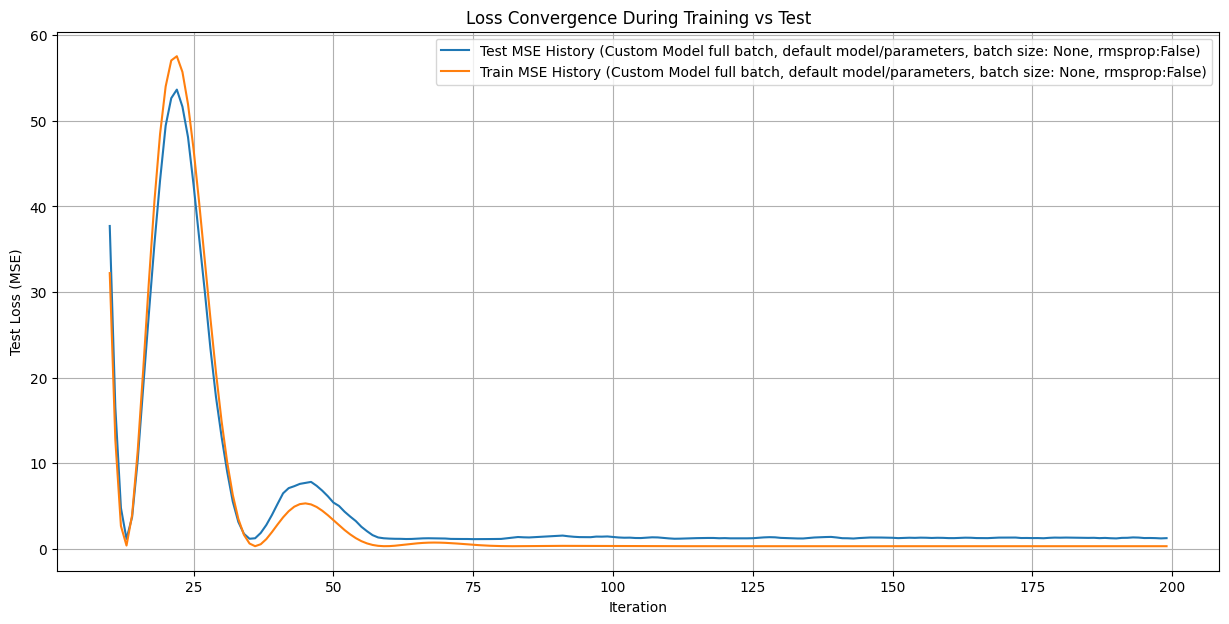

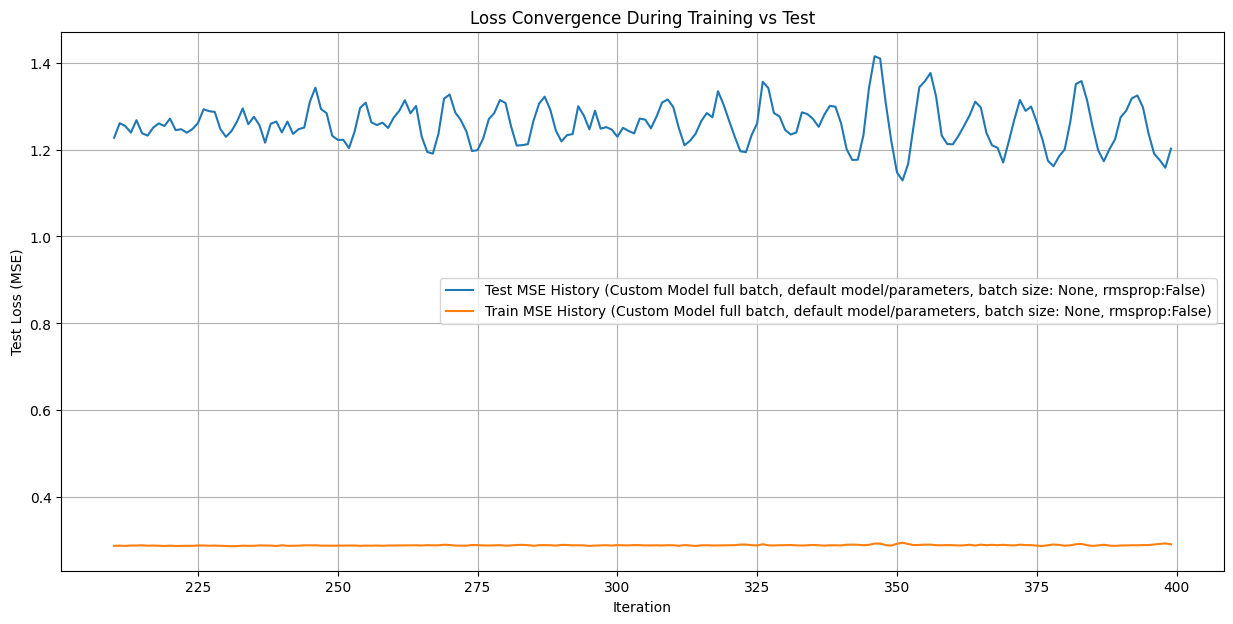

In [252]:
for start, end in zip(range(10, 300, 200), range(200, 500, 200)):    
    plt.figure(figsize=(15, 7))
    # start = 10
    # end = 200
    plt.plot(range(start,end),test_mse_history5[start:end], label=f'Test MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')
    plt.plot(range(start,end),mse_history5[start:end], label=f'Train MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')

    # plt.plot(range(start,end),mse_history6[start:end], label=f'Train MSE History (Custom Model full batch, optimized parameters, batch size: {model6.batch_size}, rmsprop:{model6.rmsprop})')
    # plt.plot(range(start,end),test_mse_history6[start:end], label=f'Test MSE History (Custom Model full batch, optimized parameters, batch size: {model6.batch_size}, rmsprop:{model6.rmsprop})')

    # plt.plot(range(start,end), np.array(vanilla_sgd_loss_history)[start:end], label='Train MSE History (SGDRegressor)')
    # plt.plot(range(start,end), np.array(test_vanilla_sgd_loss_history)[start:end], label='Test MSE History (SGDRegressor)')

    # if start <= np.argmin(mse_history5) <= end and  start <= np.argmin(test_mse_history5) <= end:
    #     plt.plot(np.argmin(mse_history5), mse_history5[np.argmin(mse_history5)], marker='o')
    #     plt.plot(np.argmin(test_mse_history5), test_mse_history5[np.argmin(test_mse_history5)], marker='o')

    # if start <= np.argmin(mse_history6) <= end and  start <= np.argmin(test_mse_history6) <= end:
    #     plt.plot(np.argmin(mse_history6), mse_history6[np.argmin(mse_history6)], marker='o')
    #     plt.plot(np.argmin(test_mse_history6), test_mse_history6[np.argmin(test_mse_history6)], marker='o') 

    # if start <= np.argmin(vanilla_sgd_loss_history) <= end and  start <= np.argmin(np.array(test_vanilla_sgd_loss_history)) <= end:
    #     plt.plot(np.argmin(vanilla_sgd_loss_history),vanilla_sgd_loss_history[np.argmin(vanilla_sgd_loss_history)], 'ro')
    #     plt.plot(np.argmin(np.array(test_vanilla_sgd_loss_history)), np.array(test_vanilla_sgd_loss_history).min(), 'ro')
    plt.xlabel("Iteration")
    plt.ylabel("Test Loss (MSE)")
    plt.title("Loss Convergence During Training vs Test")
    plt.legend()
    plt.grid(True)
    plt.show()


## Note: 
- No need to get RMSprop for full batch as it fluctuates while the loss function is always lower for ones without RMSprop.
- It is necessary to have rmsprop for mini-batch and stochastic gd.
- Mini-batch/s trade efficiency by accuracy.